## Неделя 2. Вторник 
### Обучение с учителем

### Применение ансаблей моделей для задач классификации и регрессии

In [54]:
import pandas as pd
import numpy as np
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
import category_encoders as ce
from category_encoders import CatBoostEncoder
# Metrics
from sklearn.metrics import accuracy_score

from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
# tunning hyperparamters model
import optuna

1. Загружаем предобработанный датасет (либо загружаем и очищаем, если не осталось сохраненной версии)

In [55]:
df = pd.read_csv('aux/heart.csv')

In [69]:
X , y = df.drop('HeartDisease', axis = 1), df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [70]:
num_features = X_train.select_dtypes(exclude='object').columns.tolist()
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [71]:
imputer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), num_features),
        ('cat', SimpleImputer(strategy='most_frequent'), cat_features)
    ], 
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [72]:
data_train = imputer.fit_transform(X_train)
data_test = imputer.transform(X_test)

In [73]:
encoder = ColumnTransformer(
    transformers=[
        ('encoder', CatBoostEncoder(), cat_features)
        
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [74]:
scaler = ColumnTransformer([
    ('scaler', StandardScaler(), num_features)
], 
verbose_feature_names_out=False,
remainder='passthrough'
)


In [75]:
preprocessor = Pipeline([
    ('imputer', imputer),
    ('encoder', encoder),
    ('scaler', scaler)
]

)

In [78]:
preprocessor

,steps,"[('imputer', ...), ('encoder', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [76]:
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

In [77]:
X_train_processed.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
485,0.971201,0.339016,0.127137,1.835497,-0.324520,0.317046,0.553134,0.553134,0.553134,0.553134,0.553134
486,0.118353,-1.266031,0.099443,1.835497,1.689837,-0.440356,0.776567,0.776567,0.776567,0.553134,0.553134
117,0.544777,-0.159102,1.244113,1.835497,-0.247045,0.601071,0.553134,0.553134,0.517711,0.776567,0.776567
361,-0.734495,1.501291,-1.876035,-0.544812,-0.479470,-0.819056,0.517711,0.776567,0.553134,0.851045,0.851045
296,-0.414677,0.671094,-1.876035,1.835497,0.101594,-0.156330,0.638283,0.851045,0.776567,0.888283,0.888283


2. К прежним датасетам применяем ансамбли моделей: 
    - `RandomForest`
    - `Voting`
    - `Catboost`([https://catboost.ai/en/docs/concepts/python-installation](https://catboost.ai/en/docs/concepts/python-installation))
    - `LightGBM`([https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html](https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html))
    - `XGBoost` ([https://xgboost.readthedocs.io/en/latest/install.html](https://xgboost.readthedocs.io/en/latest/install.html))

In [79]:
models = {
    'RF' : RandomForestClassifier(),
    'Cat' : CatBoostClassifier(),
    'LGBM' : lgb.LGBMClassifier(),
    'XGB' : xgb.XGBClassifier() 
}

In [80]:
list_model = list(models.items())


Voting =  VotingClassifier(
    estimators=list_model,
    voting='soft'
)

stacking = StackingClassifier(
    estimators =[
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('LGBM', lgb.LGBMClassifier(n_estimators=100, random_state=42)),
    ('XGB', xgb.XGBClassifier(n_estimators=100, random_state=42))
] ,
    final_estimator = LogisticRegression(), cv=5, passthrough=False
)

bagging = BaggingClassifier(
    estimator = DecisionTreeClassifier(max_depth=10),
    n_estimators=50,  
    max_samples=0.8,  
    max_features=0.8,  
    random_state=42,
    n_jobs=-1  )

gradient_boost  = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

all_models = {
    **models,
    'Voting' : Voting,
    'Stacking': stacking,
    'Bagging': bagging,
    'GradientBoost': gradient_boost
}

In [84]:
results = []

for name, model in all_models.items():
    try:
        model.fit(X_train_processed, y_train)

        train_acc = model.score(X_train_processed, y_train)
        test_acc = model.score(X_test_processed, y_test)

        results.append({
            'Model' : name, 
            'Train_Acc' : round(train_acc,4),
            'Test_Acc' : round(test_acc, 4),
            'Diff' : round(train_acc - test_acc)
        })
        print(f"{name:15} | Train: {train_acc:.4f} | Test: {test_acc:.4f} | Diff: {train_acc-test_acc:.4f}")

    except Exception as e:
        print(f"{name:15} | Ошибка: {str(e)[:30]}")

results_df = pd.DataFrame(results).sort_values('Test_Acc', ascending=False)
print(results_df.to_string(index=False))        


RF              | Train: 1.0000 | Test: 0.8478 | Diff: 0.1522
Learning rate set to 0.009028
0:	learn: 0.6854260	total: 3.5ms	remaining: 3.5s
1:	learn: 0.6792083	total: 5.39ms	remaining: 2.69s
2:	learn: 0.6721899	total: 7.61ms	remaining: 2.53s
3:	learn: 0.6638830	total: 9.78ms	remaining: 2.44s
4:	learn: 0.6556445	total: 11.7ms	remaining: 2.32s
5:	learn: 0.6491355	total: 13.7ms	remaining: 2.27s
6:	learn: 0.6435220	total: 15.2ms	remaining: 2.16s
7:	learn: 0.6368740	total: 17.1ms	remaining: 2.12s
8:	learn: 0.6306382	total: 19.3ms	remaining: 2.12s
9:	learn: 0.6244101	total: 22ms	remaining: 2.17s
10:	learn: 0.6181845	total: 23.7ms	remaining: 2.13s
11:	learn: 0.6113737	total: 25.3ms	remaining: 2.08s
12:	learn: 0.6053336	total: 26.8ms	remaining: 2.04s
13:	learn: 0.5988998	total: 28.9ms	remaining: 2.04s
14:	learn: 0.5927382	total: 30.8ms	remaining: 2.02s
15:	learn: 0.5866680	total: 33.5ms	remaining: 2.06s
16:	learn: 0.5807167	total: 38.6ms	remaining: 2.23s
17:	learn: 0.5757430	total: 40.7ms	rem

/usr/local/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Stacking        | Train: 1.0000 | Test: 0.8533 | Diff: 0.1467
Bagging         | Train: 0.9891 | Test: 0.8641 | Diff: 0.1250
GradientBoost   | Train: 0.9659 | Test: 0.8804 | Diff: 0.0855
        Model  Train_Acc  Test_Acc  Diff
          Cat     0.9891    0.8804     0
GradientBoost     0.9659    0.8804     0
       Voting     1.0000    0.8641     0
      Bagging     0.9891    0.8641     0
     Stacking     1.0000    0.8533     0
           RF     1.0000    0.8478     0
         LGBM     1.0000    0.8478     0
          XGB     1.0000    0.8370     0


In [86]:
results_df.head(10)

,Model,Train_Acc,Test_Acc,Diff
1,Cat,0.9891,0.8804,0
7,GradientBoost,0.9659,0.8804,0
4,Voting,1.0000,0.8641,0
6,Bagging,0.9891,0.8641,0
5,Stacking,1.0000,0.8533,0
0,RF,1.0000,0.8478,0
2,LGBM,1.0000,0.8478,0
3,XGB,1.0000,0.8370,0


# ❓
Какие значения по умолчанию заданы в случайном лесе для числа деревьев и их глубины?

> ответ тут
- n_estimators = 100
- max_depth = None

3. Прогоните модели через `optuna`, определяем лучшие параметры и сохраняем результат в словарь вида:
    ```python
    results = {'model_name' : best_result}
    ```

Типичные параметры для оптимизации градиентного бустинга: 
* число итераций алгоритма
* глубина деревьев
* скорость обучения (`learning_rate`). 
Чтобы попробовать оптимизировать модели, стоит обратиться к документации: разные реализации будут предлагать разные варианты параметров. 

   > Для классификации используем метрику `accuracy_score`

In [ ]:
def objective(trial, X_train, y_train, X_test, y_test, model_type):

    if model_type =="RF":
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            random_state=42)
        
    elif model_type == 'GradientBoosting':
            model = GradientBoostingClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 10),    
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            random_state=42
            )

    elif model_type == 'Cat':
        model = CatBoostClassifier(
            iterations=trial.suggest_int('iterations', 100, 500),
            depth=trial.suggest_int('depth', 3, 8),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            verbose=False,
            random_state=42
         )

    elif model_type == 'LGBM':
        model = lgb.LGBMClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
            random_state=42
         )
        
    elif model_type == 'XGB':
        model = xgb.XGBClassifier(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 10),
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3),
            random_state=42
         )
    else:
        # Важно: добавить ветку else для нераспознанных моделей
        raise ValueError(f"Неизвестный тип модели: {model_type}")
        
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

results = {}
for model_name in ['RF', 'Cat', 'LGBM', 'XGB', 'GradientBoosting']:
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train_processed, y_train, X_test_processed, y_test, model_name), 
                   n_trials=20, show_progress_bar=True)
    results[model_name] = {'best_value': study.best_value, 'best_params': study.best_params}
    print(f"{model_name}: {study.best_value:.4f}")







[I 2025-12-01 18:34:33,789] A new study created in memory with name: no-name-62868644-4f6b-471e-a198-b004f7045dd2


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-01 18:34:34,565] Trial 0 finished with value: 0.8695652173913043 and parameters: {'n_eestimators': 107, 'max_depth': 10}. Best is trial 0 with value: 0.8695652173913043.
[I 2025-12-01 18:34:38,464] Trial 1 finished with value: 0.8695652173913043 and parameters: {'n_eestimators': 299, 'max_depth': 8}. Best is trial 0 with value: 0.8695652173913043.
[I 2025-12-01 18:34:39,005] Trial 2 finished with value: 0.8532608695652174 and parameters: {'n_eestimators': 79, 'max_depth': 10}. Best is trial 0 with value: 0.8695652173913043.
[I 2025-12-01 18:34:39,760] Trial 3 finished with value: 0.8641304347826086 and parameters: {'n_eestimators': 221, 'max_depth': 5}. Best is trial 0 with value: 0.8695652173913043.
[I 2025-12-01 18:34:40,159] Trial 4 finished with value: 0.875 and parameters: {'n_eestimators': 121, 'max_depth': 3}. Best is trial 4 with value: 0.875.
[I 2025-12-01 18:34:40,847] Trial 5 finished with value: 0.875 and parameters: {'n_eestimators': 199, 'max_depth': 3}. Best i

[I 2025-12-01 18:34:50,229] A new study created in memory with name: no-name-3ee10218-e75a-4d86-b5f0-4cd16641a151


[I 2025-12-01 18:34:50,226] Trial 19 finished with value: 0.8641304347826086 and parameters: {'n_eestimators': 83, 'max_depth': 3}. Best is trial 4 with value: 0.875.
RF: 0.8750


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-01 18:34:50,750] Trial 0 finished with value: 0.8641304347826086 and parameters: {'iterations': 259, 'depth': 3, 'learning_rate': 0.2344033636455487}. Best is trial 0 with value: 0.8641304347826086.
[I 2025-12-01 18:34:51,443] Trial 1 finished with value: 0.8586956521739131 and parameters: {'iterations': 472, 'depth': 4, 'learning_rate': 0.15418647578783717}. Best is trial 0 with value: 0.8641304347826086.
[I 2025-12-01 18:34:51,588] Trial 2 finished with value: 0.8858695652173914 and parameters: {'iterations': 105, 'depth': 4, 'learning_rate': 0.13749506394218983}. Best is trial 2 with value: 0.8858695652173914.
[I 2025-12-01 18:34:52,111] Trial 3 finished with value: 0.8586956521739131 and parameters: {'iterations': 354, 'depth': 3, 'learning_rate': 0.1503943929787699}. Best is trial 2 with value: 0.8858695652173914.
[I 2025-12-01 18:34:52,518] Trial 4 finished with value: 0.8695652173913043 and parameters: {'iterations': 312, 'depth': 3, 'learning_rate': 0.097288205306094

[I 2025-12-01 18:35:02,159] A new study created in memory with name: no-name-ae2d1d8a-c48d-4170-9ef3-71778a537495


[I 2025-12-01 18:35:02,157] Trial 19 finished with value: 0.8858695652173914 and parameters: {'iterations': 142, 'depth': 5, 'learning_rate': 0.0989186221965401}. Best is trial 12 with value: 0.8913043478260869.
Cat: 0.8913


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-12-01 18:35:05,960] A new study created in memory with name: no-name-60b03faf-8281-406c-94f6-e80d4337b047


[I 2025-12-01 18:35:05,787] Trial 18 finished with value: 0.8369565217391305 and parameters: {'n_estimators': 196, 'max_depth': 6, 'learning_rate': 0.06724768021409162}. Best is trial 1 with value: 0.8695652173913043.
[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-01 18:35:06,391] Trial 0 finished with value: 0.842391304347826 and parameters: {'n_estimators': 123, 'max_depth': 6, 'learning_rate': 0.12413934244510112}. Best is trial 0 with value: 0.842391304347826.
[I 2025-12-01 18:35:06,566] Trial 1 finished with value: 0.8315217391304348 and parameters: {'n_estimators': 60, 'max_depth': 10, 'learning_rate': 0.2494851505217293}. Best is trial 0 with value: 0.842391304347826.
[I 2025-12-01 18:35:07,193] Trial 2 finished with value: 0.842391304347826 and parameters: {'n_estimators': 109, 'max_depth': 10, 'learning_rate': 0.03609567573215551}. Best is trial 0 with value: 0.842391304347826.
[I 2025-12-01 18:35:07,478] Trial 3 finished with value: 0.875 and parameters: {'n_estimators': 192, 'max_depth': 4, 'learning_rate': 0.09382220038239414}. Best is trial 3 with value: 0.875.
[I 2025-12-01 18:35:07,945] Trial 4 finished with value: 0.8260869565217391 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.09384261056471

[I 2025-12-01 18:35:12,478] A new study created in memory with name: no-name-40bcc76e-6523-4e05-b07b-4ebbc833c387


[I 2025-12-01 18:35:12,365] Trial 18 finished with value: 0.8695652173913043 and parameters: {'n_estimators': 82, 'max_depth': 4, 'learning_rate': 0.07229166946119903}. Best is trial 3 with value: 0.875.
[I 2025-12-01 18:35:12,471] Trial 19 finished with value: 0.8586956521739131 and parameters: {'n_estimators': 54, 'max_depth': 4, 'learning_rate': 0.051165354424949135}. Best is trial 3 with value: 0.875.
XGB: 0.8750


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-01 18:35:18,722] Trial 0 finished with value: 0.8206521739130435 and parameters: {'n_estimators': 290, 'max_depth': 8, 'learning_rate': 0.02078196479524958}. Best is trial 0 with value: 0.8206521739130435.
[I 2025-12-01 18:35:19,437] Trial 1 finished with value: 0.8532608695652174 and parameters: {'n_estimators': 64, 'max_depth': 6, 'learning_rate': 0.0967558497879792}. Best is trial 1 with value: 0.8532608695652174.
[I 2025-12-01 18:35:22,110] Trial 2 finished with value: 0.8641304347826086 and parameters: {'n_estimators': 251, 'max_depth': 6, 'learning_rate': 0.044193545267459354}. Best is trial 2 with value: 0.8641304347826086.
[I 2025-12-01 18:35:24,098] Trial 3 finished with value: 0.875 and parameters: {'n_estimators': 290, 'max_depth': 4, 'learning_rate': 0.06845456426000761}. Best is trial 3 with value: 0.875.
[I 2025-12-01 18:35:27,229] Trial 4 finished with value: 0.8315217391304348 and parameters: {'n_estimators': 158, 'max_depth': 10, 'learning_rate': 0.016352228

4. Превращаем словарь в `DataFrame` и сравниваем полученные результаты. Строим `bar_plot` для визуализации метрики качества. 

In [100]:
df = pd.DataFrame([{'Model': k, 'Accuracy': v['best_value'], **v['best_params']}
                   for k, v in results.items()])


In [102]:
df.head(10)

,Model,Accuracy,n_eestimators,max_depth,iterations,depth,learning_rate,n_estimators
0,RF,0.875000,121.0,3.0,NaN,NaN,NaN,NaN
1,Cat,0.891304,NaN,NaN,182.0,5.0,0.072392,NaN
2,LGBM,0.869565,NaN,3.0,NaN,NaN,0.161937,82.0
3,XGB,0.875000,NaN,4.0,NaN,NaN,0.093822,192.0
4,GradientBoosting,0.880435,NaN,3.0,NaN,NaN,0.283943,147.0


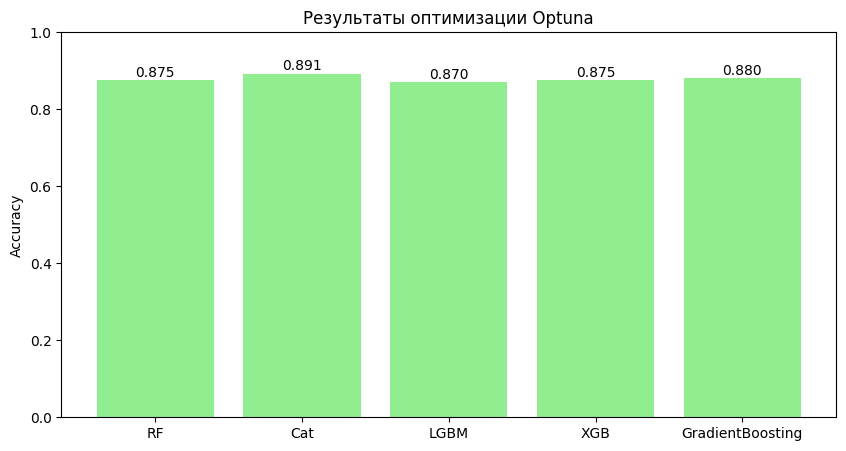

              Model  Accuracy
1               Cat  0.891304
4  GradientBoosting  0.880435
0                RF  0.875000
3               XGB  0.875000
2              LGBM  0.869565


In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(df['Model'], df['Accuracy'], color='lightgreen')
plt.ylabel('Accuracy')
plt.title('Результаты оптимизации Optuna')
plt.ylim(0, 1)
for i, acc in enumerate(df['Accuracy']):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center')
plt.show()

print(df[['Model', 'Accuracy']].sort_values('Accuracy', ascending=False))


5. Выберете лучшую модель и попробуйте задеплоить ее в Streamlit.

* Создайте просто интерфейс для пользователя, куда бы он мог ввести необходимые данные, а вы бы ему вернули предсказание

In [109]:
import pickle
import joblib
best_model_name = "Cat"
best_model = CatBoostClassifier(
    **results[best_model_name]['best_params'],
    verbose=False,
    random_state=42
)

best_model.fit(X_train_processed, y_train)

joblib.dump(best_model, 'best_model.pkl')
print(f'Модель {best_model_name} сохранена!')


if hasattr(X_train, 'columns'):
    feature_names = list(X_train.columns)
    joblib.dump(feature_names, 'feature_names.pkl')

Модель Cat сохранена!
